## Imports

In [381]:
import xml.etree.ElementTree as ET
import pandas as pd
import numpy as np
from collections import Counter
import seaborn as sns
from nltk.probability import FreqDist
from nltk.corpus import stopwords
from string import punctuation
import re
from keras.utils import to_categorical
from gensim.models import KeyedVectors
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical
from keras.models import Model
from keras.layers import Input
from keras.layers import Flatten
from keras.layers import Embedding
from keras.models import Sequential
%matplotlib inline
pylab.rcParams['figure.figsize'] = (10, 6)

## loading data

In [382]:
def load_data_from_xml(filename):
    aspect_data = {'Level0':[],'Level1':[]}
    sentences = list()
    tree = ET.parse(filename)
    root = tree.getroot()
    sentences = list()
    score= list()
    for row in root:
        sentences.append(row[2].text)
        temp = row[4].text.split('/')
        aspect_data['Level0'].append(temp[0])
        aspect_data['Level1'].append(temp[1])
    return aspect_data,sentences

In [383]:
aspect_data,sentences = load_data_from_xml('dataset/financial_posts_ABSA_train.xml')

In [384]:
print(len(sentences),len(aspect_data['Level0']),len(aspect_data['Level1']))

675 675 675


## insight into aspects 

In [385]:
aspect_data.keys()

dict_keys(['Level0', 'Level1'])

In [386]:
len(set(aspect_data['Level0']))

3

In [387]:
len(set(aspect_data['Level1']))

21

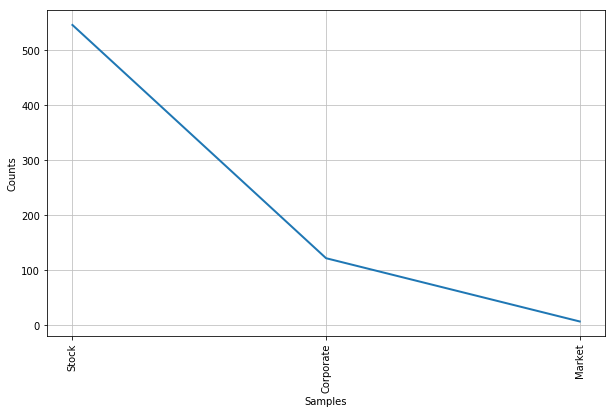

FreqDist({'Stock': 546, 'Corporate': 122, 'Market': 7})


In [388]:
level0_freq = FreqDist(aspect_data['Level0'])
level0_freq.plot()
level0_freq.pprint()

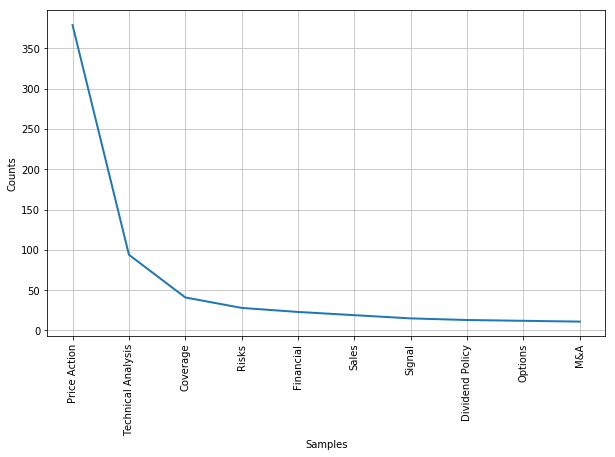

FreqDist({'Price Action': 379, 'Technical Analysis': 94, 'Coverage': 41, 'Risks': 28, 'Financial': 23, 'Sales': 19, 'Signal': 15, 'Dividend Policy': 13, 'Options': 12, 'M&A': 11, 'Strategy': 6, 'Rumors': 6, ...})


In [389]:
level1_freq = FreqDist(aspect_data['Level1'])
level1_freq.plot(10)
level1_freq.pprint(12)

In [390]:
def get_level_pairs(l1,l2):
    level_pair = dict()
    for pair in zip(l1,l2):
        if pair[1] in level_pair.keys():
            level_pair[pair[1]].append(pair[0])
        else:
            level_pair[pair[1]] = [pair[0]]
    for _ in level_pair.keys():
        level_pair[_] = set(level_pair[_])
    return level_pair

In [391]:
L0_L1_pair = get_level_pairs(aspect_data['Level0'],aspect_data['Level1'])
L1_L0_pair = get_level_pairs(aspect_data['Level1'],aspect_data['Level0'])

In [392]:
L0_L1_pair

{'Conditions': {'Market'},
 'Coverage': {'Stock'},
 'Dividend Policy': {'Corporate'},
 'Financial': {'Corporate'},
 'Fundamentals': {'Stock'},
 'Insider Activity': {'Stock'},
 'Legal': {'Corporate'},
 'M&A': {'Corporate'},
 'Market': {'Market'},
 'Options': {'Stock'},
 'Price Action': {'Stock'},
 'Regulatory': {'Corporate'},
 'Reputation': {'Corporate'},
 'Risks': {'Corporate'},
 'Rumors': {'Corporate'},
 'Sales': {'Corporate'},
 'Signal': {'Stock'},
 'Stategy': {'Corporate'},
 'Strategy': {'Corporate'},
 'Technical Analysis': {'Corporate', 'Stock'},
 'Volatility': {'Market'}}

In [393]:
L1_L0_pair

{'Corporate': {'Dividend Policy',
  'Financial',
  'Legal',
  'M&A',
  'Regulatory',
  'Reputation',
  'Risks',
  'Rumors',
  'Sales',
  'Stategy',
  'Strategy',
  'Technical Analysis'},
 'Market': {'Conditions', 'Market', 'Volatility'},
 'Stock': {'Coverage',
  'Fundamentals',
  'Insider Activity',
  'Options',
  'Price Action',
  'Signal',
  'Technical Analysis'}}

## pre - processing data

In [394]:
def clean_sentence(sentence):
    #remove multiple repeat non num-aplha char !!!!!!!!!-->!
    sentence = re.sub(r'(\W)\1{2,}', r'\1', sentence) 
    #removes alpha char repeating more than twice aaaa->aa
    sentence = re.sub(r'(\w)\1{2,}', r'\1\1', sentence)
    #removes links
    sentence = re.sub(r'(?P<url>https?://[^\s]+)', r'', sentence)
    # remove @usernames
    sentence = re.sub(r"(?:\@|https?\://)\S+", "", sentence)
    #removing stock names to see if it helps
    sentence = re.sub(r"(?:\$|https?\://)\S+", "", sentence)
    #remove # from #tags
    sentence = sentence.replace('#','')
    # split into tokens by white space
    tokens = sentence.split()
    # remove punctuation from each token
    table = str.maketrans('', '', punctuation)
    tokens = [w.translate(table) for w in tokens]
    # remove remaining tokens that are not alphabetic
#     tokens = [word for word in tokens if word.isalpha()]
#no removing non alpha words to keep stock names($ZSL)
    # filter out stop words
    stop_words = set(stopwords.words('english'))
    tokens = [w for w in tokens if not w in stop_words]
    # filter out short tokens
    tokens = [word for word in tokens if len(word) > 1]
    tokens = ' '.join(tokens)
    return tokens

In [395]:
sentences = [clean_sentence(x) for x in sentences]

In [396]:
sentences

['Slowly adding gotta careful This one biggest winners 2012',
 'Long setup MACD cross',
 'optimistic fundementals charts look like poopoo quarter',
 'might selling ahead earnings',
 'Looks good weekly chart',
 'back trendline 104',
 'RT close looking good bulls Will hold positions see close Keep buying',
 'Profit taking morning That pressure stock Im still bullish',
 'turning Coming far could go far Stock price implies pay nothing business',
 'looking good Calls active month weekly',
 'Sold 45 hedging 45 Letting calls ride solo',
 'Long setup Closed 20MA MACD cross November catalyst',
 'close 2864 ready rock roll',
 'Im liking price action currently target 2400 year end',
 'closng higher',
 'RS Sweet want break new 52week The earnings growth justifies way higher',
 'bull move ended waiting next setup',
 'Double bottom handle buy point 2951',
 'Daily chart though RSI Stoch point possible move theres lot resistance',
 'Downside breakout looks coming soon',
 'getting readyTarget plus clos

In [397]:
lengths = [len(s.split()) for s in sentences]

max len =  21


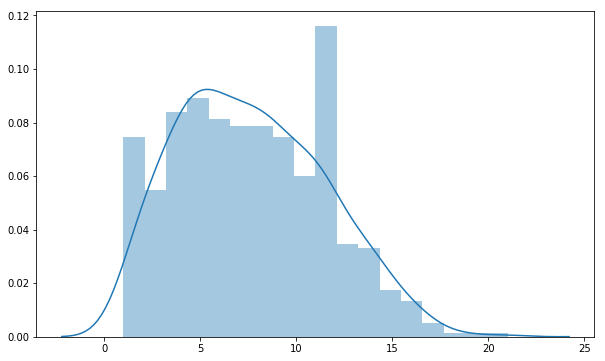

In [398]:
print('max len = ',max(lengths))
sns.distplot(lengths)

In [399]:
max_length  = 15

## Level 0 model

In [400]:
tranLines = sentences
trainLabels = aspect_data['Level0']

In [401]:
trainX,testX = tranLines[:int(len(trainLines)*0.9)],tranLines[int(len(trainLines)*0.9):]
trainY,testY = trainLabels[:int(len(trainLabels)*0.9)],trainLabels[int(len(trainLabels)*0.9):]

In [402]:
# fit a tokenizer
def create_tokenizer(lines):
    tokenizer = Tokenizer()
    tokenizer.fit_on_texts(lines)
    return tokenizer

In [403]:
# encode a list of lines
def encode_text(tokenizer, lines, length):
    # integer encode
    encoded = tokenizer.texts_to_sequences(lines)
    # pad encoded sequences
    padded = pad_sequences(encoded, maxlen=length, padding='post')
    return padded

In [404]:
# create tokenizer
tokenizer = create_tokenizer(trainX)
# calculate max document length
# calculate vocabulary size
vocab_size = len(tokenizer.word_index) + 1
print('Max document length: %d' % max_length)
print('Vocabulary size: %d' % vocab_size)
# encode data
trainX = encode_text(tokenizer, trainX, max_length)
testX = encode_text(tokenizer, testX, max_length)
print(trainX.shape,testX.shape)

Max document length: 15
Vocabulary size: 2043
(607, 15) (68, 15)


In [405]:
def convert_lables(trainY):
    temp = list()
    for x in trainY:
        if x == 'Stock':
            temp.append(0)
        elif x == 'Corporate':
            temp.append(1)
        else:
            temp.append(2)
    return to_categorical(temp)

In [406]:
trainY = convert_lables(trainY)
testY = convert_lables(testY)

In [407]:
testY

array([[0., 1., 0.],
       [1., 0., 0.],
       [0., 1., 0.],
       [0., 1., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [0., 1., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [0., 1., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [0., 1., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [0., 1., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [0., 1., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [0., 1., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [0., 1., 0.],
       [0., 1., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [0., 1., 0.],
       [1., 0., 0.],
       [1., 0

In [366]:
#loading Google Word2Vec
def load_google_word2vec(file_name):
    return KeyedVectors.load_word2vec_format(file_name, binary=True)

In [367]:
def get_word2vec_embedding_matrix(model):
    embedding_matrix = np.zeros((vocab_size,300))
    for word, i in tokenizer.word_index.items():
        try:
            embedding_vector = model[word]
        except KeyError:
            embedding_vector = None
        if embedding_vector is not None:
            embedding_matrix[i]=embedding_vector
    return embedding_matrix

In [408]:
word2vec_model= load_google_word2vec('word_embeddings/GoogleNews-vectors-negative300.bin')
embedding_matrix_word2vec = get_word2vec_embedding_matrix(word2vec_model)

In [437]:
def defina_model():
    model = Sequential()
    model.add(Embedding(vocab_size, 300,weights=[embedding_matrix_word2vec],input_length=max_len,trainable = False))
    model.add(Flatten())
    model.add(Dense(3, activation='sigmoid'))
    # compile the model
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])
    # summarize the model
    print(model.summary())
    return model

In [438]:
model = defina_model()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_6 (Embedding)      (None, 15, 300)           612900    
_________________________________________________________________
flatten_6 (Flatten)          (None, 4500)              0         
_________________________________________________________________
dense_58 (Dense)             (None, 3)                 13503     
Total params: 626,403
Trainable params: 13,503
Non-trainable params: 612,900
_________________________________________________________________
None


In [435]:
history_object = model.fit(trainX, trainY, epochs=100,batch_size=16)

Epoch 1/100
607/607 [==============================] - 0s 746us/step - loss: 0.5595 - acc: 0.8012
Epoch 2/100
607/607 [==============================] - 0s 86us/step - loss: 0.3902 - acc: 0.8792
Epoch 3/100
607/607 [==============================] - 0s 99us/step - loss: 0.3239 - acc: 0.8808
Epoch 4/100
607/607 [==============================] - 0s 96us/step - loss: 0.2818 - acc: 0.8984
Epoch 5/100
607/607 [==============================] - 0s 89us/step - loss: 0.2507 - acc: 0.9171
Epoch 6/100
607/607 [==============================] - 0s 88us/step - loss: 0.2262 - acc: 0.9303
Epoch 7/100
607/607 [==============================] - 0s 107us/step - loss: 0.2063 - acc: 0.9456
Epoch 8/100
607/607 [==============================] - 0s 99us/step - loss: 0.1891 - acc: 0.9495
Epoch 9/100
607/607 [==============================] - 0s 78us/step - loss: 0.1748 - acc: 0.9566
Epoch 10/100
607/607 [==============================] - 0s 95us/step - loss: 0.1619 - acc: 0.9632
Epoch 11/100
607/607 [=====

607/607 [==============================] - 0s 111us/step - loss: 0.0150 - acc: 1.0000
Epoch 84/100
607/607 [==============================] - 0s 111us/step - loss: 0.0147 - acc: 1.0000
Epoch 85/100
607/607 [==============================] - 0s 132us/step - loss: 0.0144 - acc: 1.0000
Epoch 86/100
607/607 [==============================] - 0s 117us/step - loss: 0.0142 - acc: 1.0000
Epoch 87/100
607/607 [==============================] - 0s 117us/step - loss: 0.0139 - acc: 1.0000
Epoch 88/100
607/607 [==============================] - 0s 110us/step - loss: 0.0137 - acc: 1.0000
Epoch 89/100
607/607 [==============================] - 0s 91us/step - loss: 0.0135 - acc: 1.0000
Epoch 90/100
607/607 [==============================] - 0s 87us/step - loss: 0.0132 - acc: 1.0000
Epoch 91/100
607/607 [==============================] - 0s 82us/step - loss: 0.0130 - acc: 1.0000
Epoch 92/100
607/607 [==============================] - 0s 100us/step - loss: 0.0128 - acc: 1.0000
Epoch 93/100
607/607 [====

In [436]:
loss,acc = model.evaluate(testX,testY)
# trainY
acc

68/68 [==============================] - 0s 3ms/step


0.8872549218289992

In [428]:
for x in model.predict(testX):
    if x.argmax()!=0:
        print(x.argmax())

1
1
1
1
1
1
1
